In [1]:
# Imports
import os
import json
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from tangermeme.io import extract_loci
from tangermeme.predict import predict
from tangermeme.plot import plot_logo
from tangermeme.deep_lift_shap import deep_lift_shap
from bpnetlite.bpnet import ControlWrapper, CountWrapper, ProfileWrapper
from bpnetlite.performance import calculate_performance_measures
from bpnetlite.chrombpnet import BPNet

from weasyprint import HTML, CSS

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


# Training curves

In [2]:
# bias model
path_log = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet-lite/v0.0.3/K562.bias.log"

In [3]:
# log dataframe
bias_log_df = pd.read_csv(path_log, sep="\t")
bias_log_df.head()

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?
0,0,0,3.041770,4.679652,237.775452,16.814980,219.552780,0.149073,0.075567,9.608156,True
1,0,100,8.999509,4.523947,166.606049,0.862055,166.646240,0.373621,0.249991,1.012549,True
2,0,200,8.836910,4.528832,135.564072,1.323950,163.962234,0.387380,0.246294,1.074701,True
3,0,300,8.813533,4.532634,163.944061,1.405823,163.128113,0.391275,0.292921,1.063992,True
4,0,400,8.834492,4.542520,157.948395,1.494479,162.780731,0.393721,0.352971,0.990623,True


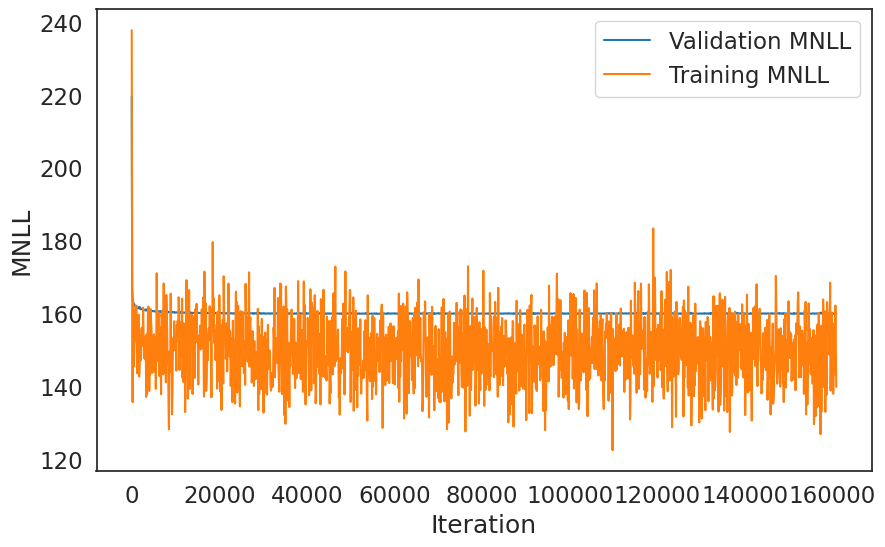

In [4]:
# Plot losses vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Iteration", y="Validation MNLL", label="Validation MNLL")
    sns.lineplot(data=bias_log_df, x="Iteration", y="Training MNLL", label="Training MNLL")
    plt.xlabel("Iteration")
    plt.ylabel("MNLL")
    plt.show()

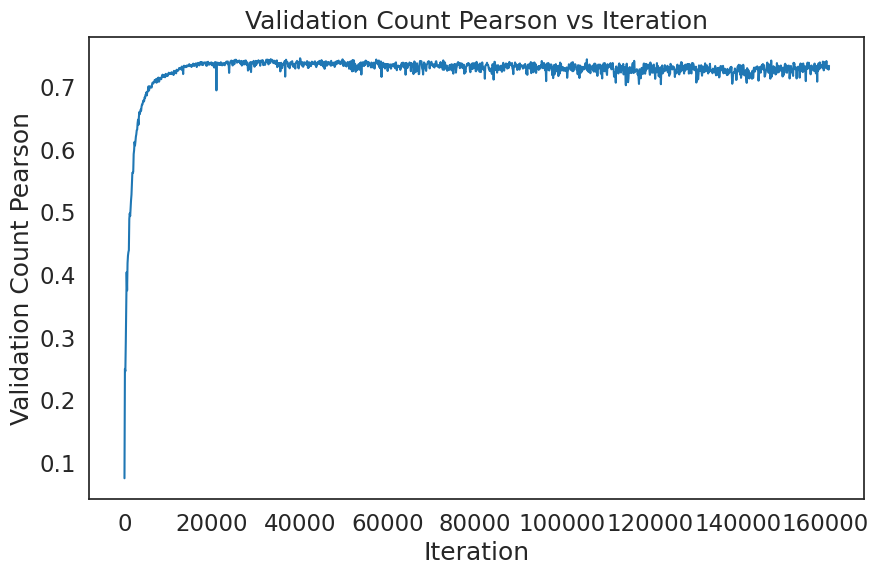

In [5]:
# Plot "Validation Count Pearson" vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Iteration", y="Validation Count Pearson")
    plt.title("Validation Count Pearson vs Iteration")
    plt.show()

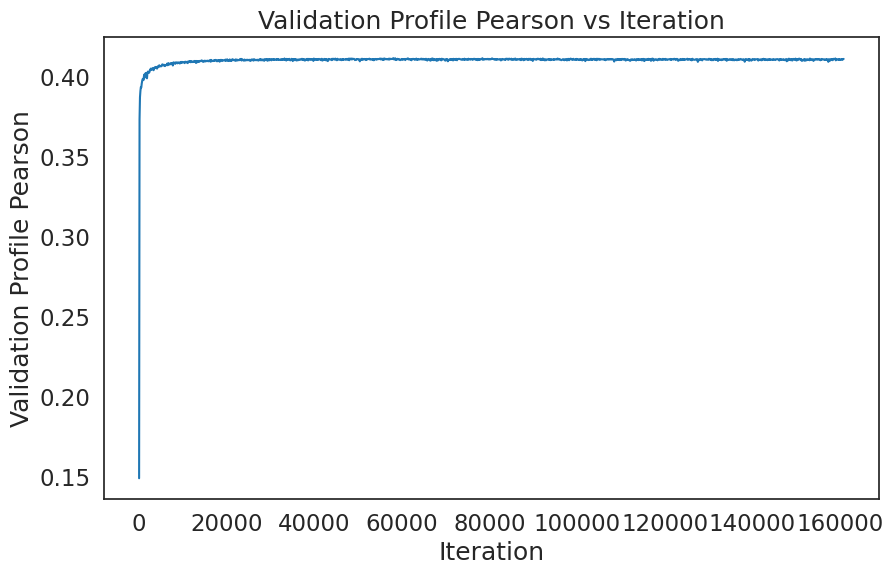

In [6]:
# Plot "Validation Profile Pearson" vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Iteration", y="Validation Profile Pearson")
    plt.title("Validation Profile Pearson vs Iteration")
    plt.show()

# Load bias model

In [7]:
path_bias_model = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/models/K562_bias.h5"

In [8]:
# Load the model
if path_bias_model.endswith(".h5"):
    bias_model = BPNet.from_chrombpnet(path_bias_model).cuda().eval()
elif path_bias_model.endswith(".torch"):
    bias_model = torch.load(path_bias_model, map_location="cuda").eval()
bias_model

BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# Bias model performance

In [9]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

In [10]:
def calculate_performance_measures_on_loci(
    model,
    loci,
    signals,
    sequences,
    chroms,
    recalculate_interval=False,
    seq_len=2114,
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
):
    """
    Calculate performance measures on loci
    """
    # read loci
    loci_df = pd.read_csv(loci, sep="\t", header=None, names=NARROWPEAK_SCHEMA)
    if recalculate_interval:
        loci_df["start"] = loci_df["start"] + loci_df["summit"] - seq_len // 2
        loci_df["end"] = loci_df["start"] + seq_len
    loci_df = loci_df[loci_df["chr"].isin(chroms)]
    print(f"Number of loci: {len(loci_df)}")

    # extract loci
    loci_seqs, loci_signals = extract_loci(
        loci_df,
        sequences,
        signals=signals,
        ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
    )

    # predict
    loci_pred_signal, loci_predicted_cnts = predict(model=model, X=loci_seqs)

    # calculate performance measures
    y_profile = loci_pred_signal
    y_counts = loci_predicted_cnts
    y = loci_signals
    z = y_profile.shape
    y_profile = y_profile.reshape(y_profile.shape[0], -1)
    y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
    y_profile = y_profile.reshape(*z)
    measures = calculate_performance_measures(
        y_profile, 
        y, 
        y_counts, 
        kernel_sigma=kernel_sigma, 
        kernel_width=kernel_width, 
        measures=measures
    )

    return measures

In [11]:
path_peaks = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/ENCSR868FGK_K562_ATAC-seq_peaks.bed"
path_negatives = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_negatives.bed"
path_signal = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_unstranded_counts.bw"
path_fa = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/hg38.fa"
path_splits = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/fold_0.json"

In [12]:
# Load splits
splits = json.load(open(path_splits, "r"))
splits

{'test': ['chr1', 'chr3', 'chr6'],
 'valid': ['chr8', 'chr20'],
 'train': ['chr2',
  'chr4',
  'chr5',
  'chr7',
  'chr9',
  'chr10',
  'chr11',
  'chr12',
  'chr13',
  'chr14',
  'chr15',
  'chr16',
  'chr17',
  'chr18',
  'chr19',
  'chr21',
  'chr22',
  'chrX',
  'chrY']}

In [13]:
# Calculate performance measures on test peaks
test_peaks_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_peaks,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=True,
    seq_len=2114,
    chroms=splits["test"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
test_peaks_performance

Number of loci: 66484


{'profile_mnll': tensor([[ 768.7109],
         [ 525.3326],
         [ 759.9639],
         ...,
         [1369.9006],
         [1270.4602],
         [ 603.9904]]),
 'profile_pearson': tensor([[0.8817],
         [0.7565],
         [0.8897],
         ...,
         [0.3843],
         [0.4197],
         [0.5872]]),
 'count_pearson': tensor([-0.2375]),
 'count_mse': tensor([9.5023])}

In [14]:
# Calculate performance measures on test negatives
test_negatives_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_negatives,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=False,
    chroms=splits["test"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
test_negatives_performance

Number of loci: 40817


{'profile_mnll': tensor([[16.5273],
         [22.0911],
         [22.5960],
         ...,
         [18.5778],
         [43.2203],
         [13.5572]]),
 'profile_pearson': tensor([[0.0354],
         [0.1915],
         [0.0618],
         ...,
         [0.1390],
         [0.1506],
         [0.0135]]),
 'count_pearson': tensor([0.7025]),
 'count_mse': tensor([0.6987])}

# Contribution scores from bias model

In [15]:
path_subsample_peaks = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/chrombpnet/auxiliary/30K_subsample_peaks.bed"
path_out = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation"

In [16]:
X = extract_loci(
    loci=path_subsample_peaks,
    sequences=path_fa,
    max_jitter=0,
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
    verbose=True,
)
X.shape

Loading Loci: 100%|██████████| 30000/30000 [00:05<00:00, 5844.60it/s]


torch.Size([30000, 4, 2114])

In [17]:
X = X[X.sum(dim=(1, 2)) == X.shape[-1]]
X.shape

torch.Size([29992, 4, 2114])

In [60]:
#np.savez_compressed(os.path.join(path_out, "ohe"), X)

## Counts contribution scores

In [20]:
wrapper = CountWrapper(ControlWrapper(bias_model)).cuda().eval()
wrapper

CountWrapper(
  (model): ControlWrapper(
    (model): BPNet(
      (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
      (irelu): ReLU()
      (rconvs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
      )
      (rrelus): ModuleList(
        (0-3): 4 x ReLU()
      )
      (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
      (linear): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [63]:
X_attr = deep_lift_shap(
    wrapper.type(torch.float32), 
    X.type(torch.float32),
    hypothetical=True,
    n_shuffles=20,
    batch_size=128,
    random_state=1234,
    verbose=True,
    warning_threshold=0.001
)

100%|██████████| 599840/599840 [22:39<00:00, 441.28it/s]


In [64]:
np.savez_compressed(os.path.join(path_out, "K562.bias.counts"), X_attr)

## Profile contribution scores

In [21]:
wrapper_profile = ProfileWrapper(ControlWrapper(bias_model)).cuda().eval()

In [23]:
from bpnetlite.bpnet import _ProfileLogitScaling
from tangermeme.deep_lift_shap import _nonlinear

In [ ]:
X_attr = deep_lift_shap(
    wrapper.type(torch.float64), 
    X.type(torch.float64),
    hypothetical=True,
    n_shuffles=20,
    batch_size=32,
    random_state=1234,
    verbose=True,
    warning_threshold=0.001,
    additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear},
)

  1%|▏         | 8576/599840 [01:54<2:12:55, 74.13it/s]

In [31]:
X_attr.shape

torch.Size([29992, 4, 2114])

In [ ]:
np.savez_compressed(os.path.join(path_out, "K562.bias.profile"), X_attr)

# TF-modisco motifs

In [26]:
def convert_html_to_pdf(
	input_html,
	output_pdf
):
	css = CSS(string='''
		@page {
    		size: 1800mm 1300mm;
    		margin: 0in 0in 0in 0in;
		}
	''')
	HTML(input_html).write_pdf(output_pdf, stylesheets=[css])

## Counts contribution scores

```bash
ohe=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/ohe.npz
attrs=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.counts.npz
out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.counts.modisco.h5
cmd="modisco motifs \
-s $ohe \
-a $attrs \
-n 50000 \
-w 500 \
-o $out"
echo $cmd
eval $cmd
```

```bash
report_in=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.counts.modisco.h5
report_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_counts
motifs=/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt
cmd="modisco report \
-i $report_in \
-o $report_out \
-s $report_out \
-m $motifs"
echo $cmd
eval $cmd
```

In [29]:
convert_html_to_pdf(
    input_html="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_counts/motifs.html",
    output_pdf="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.counts.pdf"
)

## Profile contribution scores

```bash
ohe=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/ohe.npz
attrs=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.npz
out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.modisco.h5
cmd="modisco motifs \
-s $ohe \
-a $attrs \
-n 50000 \
-w 500 \
-o $out"
echo $cmd
eval $cmd
```

```bash
report_in=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.modisco.h5
report_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_profile
motifs=/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt
cmd="modisco report \
-i $report_in \
-o $report_out \
-s $report_out \
-m $motifs"
echo $cmd
eval $cmd
```

In [30]:
convert_html_to_pdf(
    input_html="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_profile/motifs.html",
    output_pdf="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.pdf"
)

# DONE!

---

# Training + validation performance

In [86]:
# Calculate performance measures on training peaks
training_peaks_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_peaks,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=True,
    seq_len=2114,
    chroms=splits["train"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
training_peaks_performance

Number of loci: 185699


{'profile_mnll': tensor([[ 742.0286],
         [2599.6279],
         [1686.3369],
         ...,
         [ 431.1780],
         [ 558.5352],
         [ 563.1091]]),
 'profile_pearson': tensor([[0.7833],
         [0.6379],
         [0.7464],
         ...,
         [0.4443],
         [0.2507],
         [0.6213]]),
 'count_pearson': tensor([-0.4452]),
 'count_mse': tensor([11.2730])}

In [87]:
# Calculate performance measures on validation peaks
validation_peaks_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_peaks,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=True,
    seq_len=2114,
    chroms=splits["valid"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
validation_peaks_performance

Number of loci: 17617


{'profile_mnll': tensor([[ 396.8701],
         [ 520.2432],
         [ 440.9164],
         ...,
         [1600.7969],
         [1698.9365],
         [ 452.9985]]),
 'profile_pearson': tensor([[0.7157],
         [0.6935],
         [0.6303],
         ...,
         [0.8214],
         [0.7681],
         [0.6580]]),
 'count_pearson': tensor([-0.4565]),
 'count_mse': tensor([10.7086])}

In [89]:
# Calculate performance measures on training negatives
training_negatives_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_negatives,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=False,
    chroms=splits["train"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
training_negatives_performance

Number of loci: 207500


{'profile_mnll': tensor([[ 11.0688],
         [  0.0000],
         [ 96.8514],
         ...,
         [ 14.5086],
         [ 57.7039],
         [176.7577]]),
 'profile_pearson': tensor([[0.0504],
         [0.0000],
         [0.2656],
         ...,
         [0.1218],
         [0.1995],
         [0.4137]]),
 'count_pearson': tensor([0.6834]),
 'count_mse': tensor([0.7300])}

In [90]:
# Calculate performance measures on validation negatives
validation_negatives_performance = calculate_performance_measures_on_loci(
    model=bias_model,
    loci=path_negatives,
    signals=[path_signal],
    sequences=path_fa,
    recalculate_interval=False,
    chroms=splits["valid"],
    kernel_sigma=7,
    kernel_width=81,
    measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson'],
)
validation_negatives_performance

Number of loci: 21457


{'profile_mnll': tensor([[279.0711],
         [154.9761],
         [184.4812],
         ...,
         [191.0447],
         [174.3915],
         [124.0468]]),
 'profile_pearson': tensor([[0.3084],
         [0.2421],
         [0.5891],
         ...,
         [0.3869],
         [0.5081],
         [0.4204]]),
 'count_pearson': tensor([0.7413]),
 'count_mse': tensor([0.4597])}